In [13]:
import gymnasium as gym
import gym_simplegrid
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression

In [15]:
# 1. Setup the environment
env_id = 'SimpleGrid-8x8-v0'
env = gym.make('SimpleGrid-8x8-v0', render_mode='human')

In [17]:
target_model = PPO('MlpPolicy', env, verbose=1)
target_model.learn(total_timesteps=10000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 160      |
|    ep_rew_mean     | -49.2    |
| time/              |          |
|    fps             | 7        |
|    iterations      | 1        |
|    time_elapsed    | 272      |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 156         |
|    ep_rew_mean          | -42.9       |
| time/                   |             |
|    fps                  | 5           |
|    iterations           | 2           |
|    time_elapsed         | 707         |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.012760969 |
|    clip_fraction        | 0.0757      |
|    clip_range           | 0.2         |
|    entropy_loss   

Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 134      |
|    ep_rew_mean     | -38.8    |
| time/              |          |
|    fps             | 55       |
|    iterations      | 1        |
|    time_elapsed    | 37       |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 107         |
|    ep_rew_mean          | -26.8       |
| time/                   |             |
|    fps                  | 55          |
|    iterations           | 2           |
|    time_elapsed         | 74          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.011464032 |
|    clip_fraction        | 0.0578      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.38       |
|    explained_variance   | -0.0131     |
|    learning

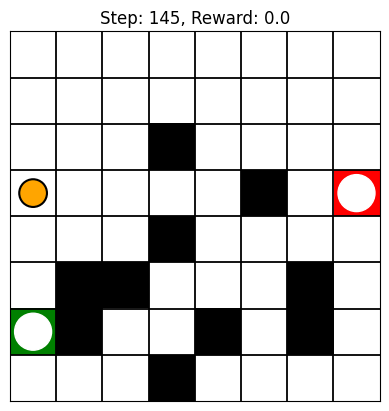

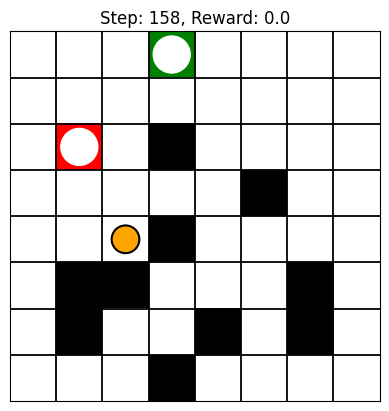

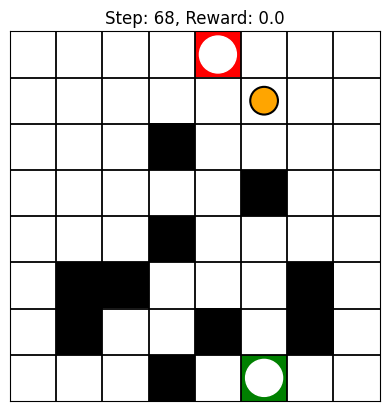

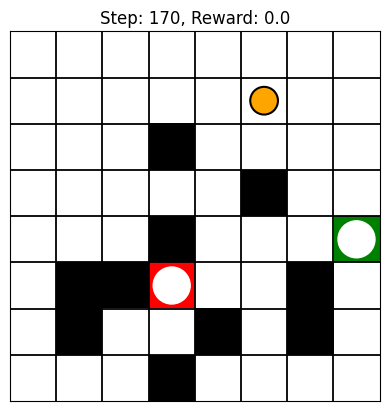

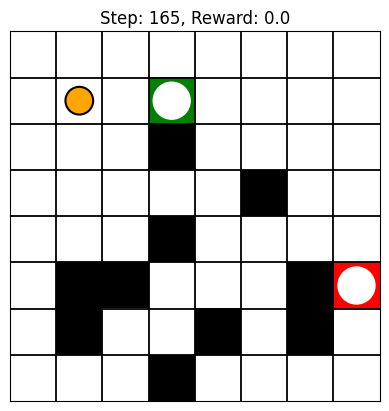

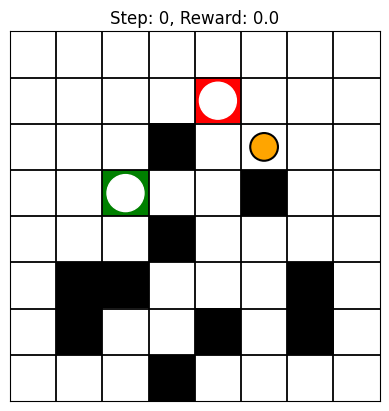

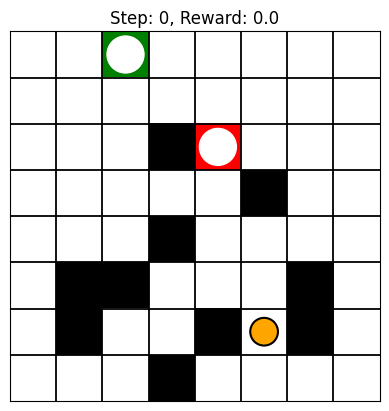

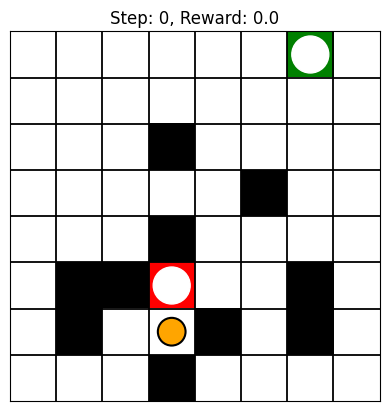

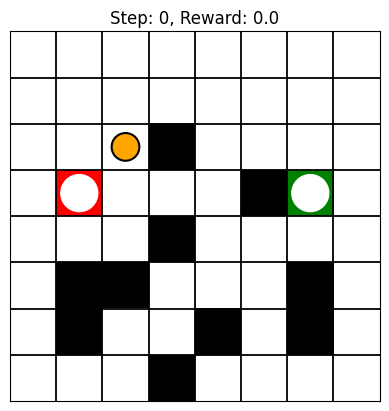

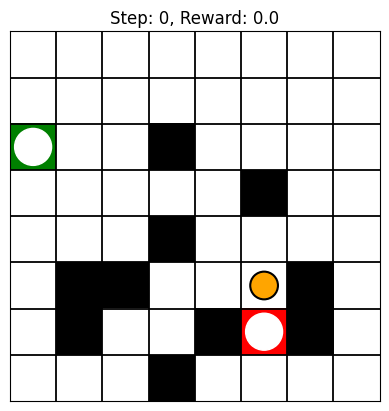

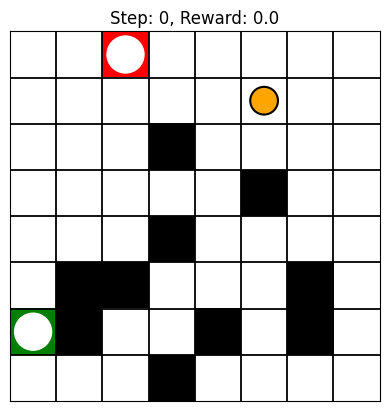

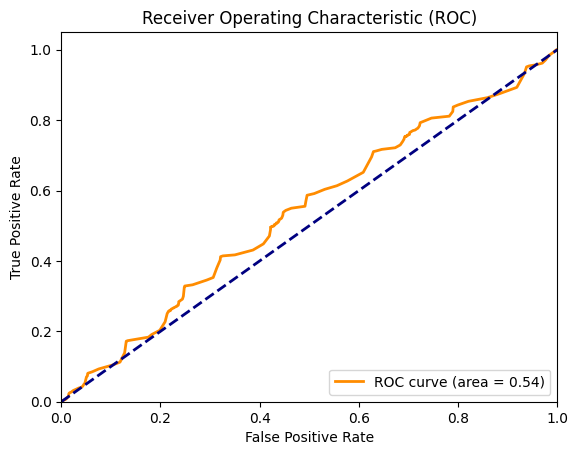

In [19]:
def train_shadow_model(env_id, total_timesteps=10000):
    shadow_env = make_vec_env(env_id, n_envs=1)
    shadow_model = PPO('MlpPolicy', shadow_env, verbose=1)
    shadow_model.learn(total_timesteps=total_timesteps)
    return shadow_model

shadow_models = [train_shadow_model(env_id) for _ in range(5)]

# 4. Collect data from shadow models
def collect_data(model, env_id, n_episodes=100):
    env = make_vec_env(env_id, n_envs=1)
    data = []
    for _ in range(n_episodes):
        obs = env.reset()
        done = False
        while not done:
            action, _ = model.predict(obs)
            new_obs, reward, done, _ = env.step(action)
            data.append((obs, action, reward, new_obs))
            obs = new_obs
    return data

shadow_data = [collect_data(model, env_id) for model in shadow_models]

# 5. Prepare data for attack model
def prepare_attack_data(shadow_data, target_model, env_id, n_episodes=100):
    attack_data = []
    for data in shadow_data:
        for obs, action, reward, new_obs in data:
            attack_data.append((obs, action, reward, new_obs, 1))  # 1 indicates in-training set
    # Collect data from target model for out-training set
    target_data = collect_data(target_model, env_id, n_episodes)
    for obs, action, reward, new_obs in target_data:
        attack_data.append((obs, action, reward, new_obs, 0))  # 0 indicates out-training set
    return attack_data

attack_data = prepare_attack_data(shadow_data, target_model, env_id)

# 6. Train attack model
X = []
y = []
for obs, action, reward, new_obs, label in attack_data:
    X.append(np.concatenate((obs.flatten(), action.flatten(), np.array([reward]).flatten())))
    y.append(label)

X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
attack_model = LogisticRegression()
attack_model.fit(X_train, y_train)

# 7. Evaluate attack model
y_pred = attack_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# 8. Visualization
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()